# Detector de Autos con YOLOv8
## Dataset: Roboflow (10,000 imagenes)

**Objetivo:** Entrenar modelo para detectar autos genericos desde webcam

**Estructura del proyecto:**
1. Deteccion de autos (este notebook)
2. Clasificacion de logos de marcas (futuro)
3. Deteccion de color (futuro)
4. Lectura de placas (futuro)

## 1. Configuracion inicial

In [1]:
# Verificar GPU disponible
!nvidia-smi

Thu Nov 13 23:05:29 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   53C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Instalar dependencias
!pip install -q ultralytics==8.3.34

import os
import sys
import shutil
import yaml
from pathlib import Path
import matplotlib.pyplot as plt
from collections import Counter
import time

from ultralytics import YOLO
import torch

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA disponible: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.4/887.4 kB 10.9 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
PyTorch version: 2.8.0+cu126
CUDA disponible: True
GPU: Tesla T4


In [3]:
# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2. Cargar y verificar dataset

In [4]:
# Ruta al ZIP en Google Drive (ajustar segun tu estructura)
ZIP_PATH = "/content/drive/MyDrive/datasets/archive.zip"

# Descomprimir dataset
EXTRACT_PATH = "/content/car_detection_dataset"
!unzip -q "$ZIP_PATH" -d "$EXTRACT_PATH"

# Verificar estructura
dataset_root = Path(EXTRACT_PATH)
print("Estructura del dataset:")
!ls -R "$EXTRACT_PATH" | head -n 30

Estructura del dataset:
/content/car_detection_dataset:
data.yaml
README.dataset.txt
README.roboflow.txt
test
train
valid

/content/car_detection_dataset/test:
images
labels

/content/car_detection_dataset/test/images:
000297578acb067b_jpg.rf.4748165575afa020176198742f43f305.jpg
0002cebd6f0cd7e1_jpg.rf.aae0f0f75662afb919f0b48993780db3.jpg
0003b0bf24238450_jpg.rf.08e255b0c6e9ec447e08c3903c16f8ea.jpg
00041cc3701f7805_jpg.rf.107187981a759d1f036923ac4d91eb7a.jpg
000472189adb5cbd_jpg.rf.1159b5f6af54206fc6628fd5a4c94f4c.jpg
00049e69cdd23a3d_jpg.rf.a7fd54ab44cf1a7565f907739197ef23.jpg
0004c9478eeda995_jpg.rf.50ff069d1424a227197d2b3c3b4c207b.jpg
0004d295cfb46842_jpg.rf.1fbd3476be9c83fa486b4f01d8135377.jpg
00058138dc1ecd17_jpg.rf.dfeb1ef3fc9206d4b11e27dd953cd7ac.jpg
0005ea10e0e14db1_jpg.rf.185170caee524d2b9e1d71df3ff5f221.jpg
000823904818a6c4_jpg.rf.373174a23083ffb0126dc33ee07de88f.jpg
000c38aad66307c5_jpg.rf.11a141158e536cc15668e700109e6fe1.jpg
000d2e3d33b18463_jpg.rf.5fe2ab00cbbc1fc938a1e89ae

In [5]:
# Verificar archivos y contar imagenes
def verify_dataset_structure(dataset_path):
    dataset_path = Path(dataset_path)

    print("=" * 60)
    print("VERIFICACION DE DATASET")
    print("=" * 60)

    # Verificar data.yaml
    data_yaml = dataset_path / "data.yaml"
    if not data_yaml.exists():
        print("[ERROR] data.yaml no encontrado")
        return False

    with open(data_yaml, 'r') as f:
        config = yaml.safe_load(f)
        print(f"\nClases: {config.get('names', {})}")
        print(f"Numero de clases: {config.get('nc', 0)}")

    # Verificar splits
    splits = ['train', 'valid', 'test']
    total_images = 0
    total_labels = 0

    for split in splits:
        img_dir = dataset_path / split / 'images'
        label_dir = dataset_path / split / 'labels'

        if not img_dir.exists():
            print(f"\n[WARNING] {split}/images no existe")
            continue

        images = list(img_dir.glob('*.jpg')) + list(img_dir.glob('*.png'))
        labels = list(label_dir.glob('*.txt')) if label_dir.exists() else []

        print(f"\n{split.upper()}:")
        print(f"  Imagenes: {len(images)}")
        print(f"  Labels: {len(labels)}")

        # Verificar correspondencia imagen-label
        missing_labels = 0
        for img in images:
            label_file = label_dir / (img.stem + '.txt')
            if not label_file.exists():
                missing_labels += 1

        if missing_labels > 0:
            print(f"  [WARNING] {missing_labels} imagenes sin label")

        total_images += len(images)
        total_labels += len(labels)

    print(f"\n{'='*60}")
    print(f"TOTAL: {total_images} imagenes, {total_labels} labels")
    print(f"{'='*60}")

    return True

# Ejecutar verificacion
verify_dataset_structure(EXTRACT_PATH)

VERIFICACION DE DATASET

Clases: ['0 Car']
Numero de clases: 1

TRAIN:
  Imagenes: 7500
  Labels: 7500

VALID:
  Imagenes: 1500
  Labels: 1500

TEST:
  Imagenes: 1000
  Labels: 1000

TOTAL: 10000 imagenes, 10000 labels


True


TRAIN - Analisis de anotaciones:
Promedio de autos por imagen: 2.81
Max autos en una imagen: 53
Min autos en una imagen: 1
Imagenes con 1 auto: 3167
Imagenes con 2+ autos: 4333

Distribucion de tamanos de bounding boxes:
  Pequenos (<5% imagen): 13451 (63.9%)
  Medianos (5-30%): 4259 (20.2%)
  Grandes (>30%): 3348 (15.9%)


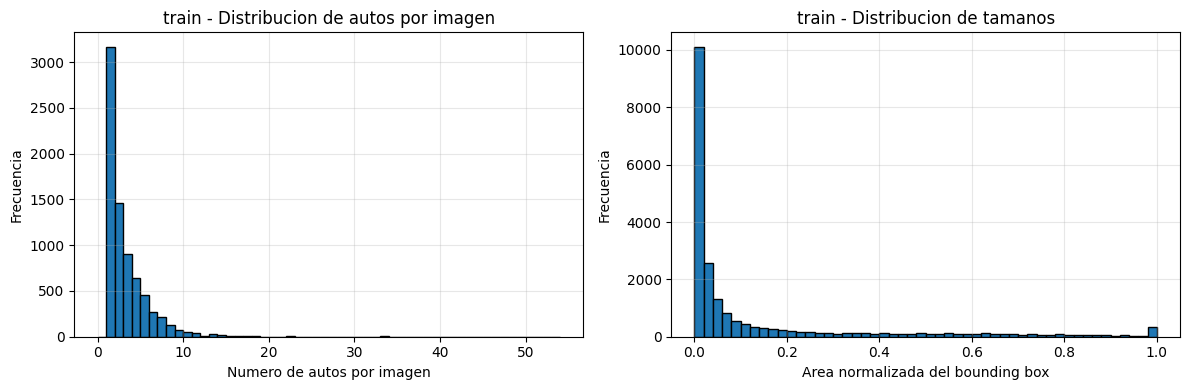


VALID - Analisis de anotaciones:
Promedio de autos por imagen: 2.83
Max autos en una imagen: 26
Min autos en una imagen: 1
Imagenes con 1 auto: 624
Imagenes con 2+ autos: 876

Distribucion de tamanos de bounding boxes:
  Pequenos (<5% imagen): 2655 (62.6%)
  Medianos (5-30%): 897 (21.2%)
  Grandes (>30%): 686 (16.2%)


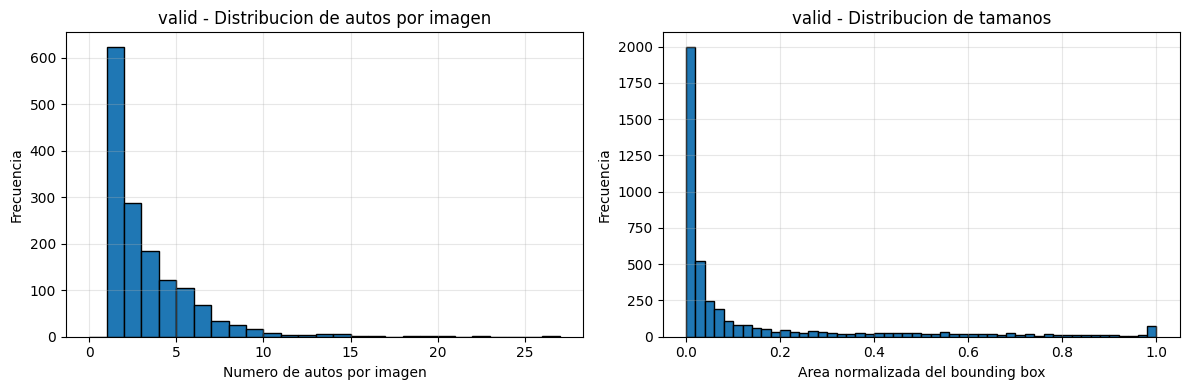

In [6]:
# Analizar distribucion de bounding boxes
def analyze_bbox_distribution(dataset_path, split='train'):
    dataset_path = Path(dataset_path)
    label_dir = dataset_path / split / 'labels'

    bbox_counts = []
    bbox_areas = []

    for label_file in label_dir.glob('*.txt'):
        with open(label_file, 'r') as f:
            lines = [l.strip() for l in f.readlines() if l.strip()]
            bbox_counts.append(len(lines))

            for line in lines:
                parts = line.split()
                if len(parts) == 5:
                    _, x, y, w, h = map(float, parts)
                    bbox_areas.append(w * h)

    print(f"\n{split.upper()} - Analisis de anotaciones:")
    print(f"Promedio de autos por imagen: {sum(bbox_counts)/len(bbox_counts):.2f}")
    print(f"Max autos en una imagen: {max(bbox_counts)}")
    print(f"Min autos en una imagen: {min(bbox_counts)}")
    print(f"Imagenes con 1 auto: {bbox_counts.count(1)}")
    print(f"Imagenes con 2+ autos: {sum(1 for c in bbox_counts if c >= 2)}")

    # Distribucion de tamanos
    small = sum(1 for a in bbox_areas if a < 0.05)
    medium = sum(1 for a in bbox_areas if 0.05 <= a < 0.3)
    large = sum(1 for a in bbox_areas if a >= 0.3)

    print(f"\nDistribucion de tamanos de bounding boxes:")
    print(f"  Pequenos (<5% imagen): {small} ({small/len(bbox_areas)*100:.1f}%)")
    print(f"  Medianos (5-30%): {medium} ({medium/len(bbox_areas)*100:.1f}%)")
    print(f"  Grandes (>30%): {large} ({large/len(bbox_areas)*100:.1f}%)")

    # Graficos
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].hist(bbox_counts, bins=range(max(bbox_counts)+2), edgecolor='black')
    axes[0].set_xlabel('Numero de autos por imagen')
    axes[0].set_ylabel('Frecuencia')
    axes[0].set_title(f'{split} - Distribucion de autos por imagen')
    axes[0].grid(True, alpha=0.3)

    axes[1].hist(bbox_areas, bins=50, edgecolor='black')
    axes[1].set_xlabel('Area normalizada del bounding box')
    axes[1].set_ylabel('Frecuencia')
    axes[1].set_title(f'{split} - Distribucion de tamanos')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'/content/{split}_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()

# Analizar train y valid
for split in ['train', 'valid']:
    analyze_bbox_distribution(EXTRACT_PATH, split)

## 3. Configuracion del modelo y entrenamiento

In [7]:
# Configuracion de paths
DATA_YAML = Path(EXTRACT_PATH) / "data.yaml"
PROJECT_DIR = "/content/runs"
RUN_NAME = "car_detector_roboflow_10k"

# Hiperparametros
MODEL_SIZE = "yolov8m.pt"  # yolov8n, yolov8s, yolov8m, yolov8l, yolov8x
EPOCHS = 50
BATCH_SIZE = 16  # Ajustar segun GPU (16 para T4, 32 para A100)
IMG_SIZE = 640
PATIENCE = 10

print(f"Configuracion:")
print(f"  Modelo: {MODEL_SIZE}")
print(f"  Epochs: {EPOCHS}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Image size: {IMG_SIZE}")
print(f"  Patience: {PATIENCE}")
print(f"\nData YAML: {DATA_YAML}")
print(f"Directorio de salida: {PROJECT_DIR}/{RUN_NAME}")

Configuracion:
  Modelo: yolov8m.pt
  Epochs: 50
  Batch size: 16
  Image size: 640
  Patience: 10

Data YAML: /content/car_detection_dataset/data.yaml
Directorio de salida: /content/runs/car_detector_roboflow_10k


In [8]:
# Cargar modelo preentrenado
model = YOLO(MODEL_SIZE)

# Entrenar
print("Iniciando entrenamiento...\n")
results = model.train(
    data=str(DATA_YAML),
    epochs=EPOCHS,
    patience=PATIENCE,
    batch=BATCH_SIZE,
    imgsz=IMG_SIZE,

    # Data augmentation (configurado para webcam realista)
    hsv_h=0.0,        # Sin cambio de hue (necesitas colores reales)
    hsv_s=0.0,        # Sin cambio de saturacion
    hsv_v=0.2,        # Solo variacion de brillo (iluminacion)
    degrees=15,       # Rotacion maxima de 15 grados
    translate=0.1,    # Desplazamiento del 10%
    scale=0.3,        # Escala +-30%
    fliplr=0.5,       # Flip horizontal 50%
    flipud=0.0,       # Sin flip vertical (autos no aparecen al reves)
    mosaic=0.5,       # Mosaic con probabilidad 50%
    mixup=0.0,        # Sin mixup (genera composiciones irreales)

    # Optimizador
    optimizer="AdamW",
    lr0=0.001,        # Learning rate inicial
    lrf=0.01,         # Learning rate final (factor)
    momentum=0.937,
    weight_decay=0.0005,
    warmup_epochs=3,  # Warmup para estabilizar entrenamiento
    warmup_momentum=0.8,
    warmup_bias_lr=0.1,

    # Guardado y logging
    save=True,
    save_period=5,    # Guardar checkpoint cada 5 epochs
    project=PROJECT_DIR,
    name=RUN_NAME,
    exist_ok=False,

    # Validacion y metricas
    val=True,
    plots=True,
    verbose=True,

    # Performance
    workers=8,
    device=0,         # GPU 0
)

100%|██████████| 49.7M/49.7M [00:01<00:00, 42.0MB/s]


Iniciando entrenamiento...

New https://pypi.org/project/ultralytics/8.3.228 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.34 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/car_detection_dataset/data.yaml, epochs=50, time=None, patience=10, batch=16, imgsz=640, save=True, save_period=5, cache=False, device=0, workers=8, project=/content/runs, name=car_detector_roboflow_10k, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, cl

100%|██████████| 755k/755k [00:00<00:00, 5.15MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 18.7MB/s]


AMP: checks passed ✅


train: Scanning /content/car_detection_dataset/train/labels... 7500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7500/7500 [00:03<00:00, 2482.48it/s]

train: WARNING ⚠️ /content/car_detection_dataset/train/images/004eee32a983a20c_jpg.rf.ae7750a432e4d5bfd9b04bcd679078be.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/car_detection_dataset/train/images/062cbccfb2e2e509_jpg.rf.15b43d720b30bd18e54509b1865677ae.jpg: 1 duplicate labels removed


train: New cache created: /content/car_detection_dataset/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.12/dist-packages/ultralytics/data/augment.py:1850: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning /content/car_detection_dataset/valid/labels... 1500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1500/1500 [00:01<00:00, 1367.09it/s]


val: New cache created: /content/car_detection_dataset/valid/labels.cache
Plotting labels to /content/runs/car_detector_roboflow_10k/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/runs/car_detector_roboflow_10k
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      7.11G      1.504      1.535      1.718         45        640: 100%|██████████| 469/469 [04:15<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:22<00:00,  2.10it/s]


                   all       1500       4238      0.472      0.435      0.429      0.224

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      7.06G      1.523      1.581      1.766         39        640: 100%|██████████| 469/469 [04:12<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:21<00:00,  2.17it/s]


                   all       1500       4238      0.552      0.462      0.461      0.214

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      7.16G      1.487      1.544      1.736         48        640: 100%|██████████| 469/469 [04:10<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:21<00:00,  2.20it/s]


                   all       1500       4238      0.655      0.504      0.554      0.311

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      7.06G      1.431       1.45      1.688         51        640: 100%|██████████| 469/469 [04:09<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:21<00:00,  2.22it/s]

                   all       1500       4238      0.656       0.54      0.592      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      7.13G      1.393      1.386      1.654         25        640: 100%|██████████| 469/469 [04:09<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:21<00:00,  2.22it/s]


                   all       1500       4238        0.7      0.562      0.623      0.377

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      7.17G      1.343      1.314      1.614         53        640: 100%|██████████| 469/469 [04:10<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:20<00:00,  2.24it/s]

                   all       1500       4238      0.704      0.592      0.646      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      7.16G      1.327       1.28      1.601         55        640: 100%|██████████| 469/469 [04:10<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:20<00:00,  2.24it/s]

                   all       1500       4238      0.683      0.601      0.648      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      7.03G      1.305      1.243      1.585         37        640: 100%|██████████| 469/469 [04:10<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:20<00:00,  2.25it/s]

                   all       1500       4238      0.715      0.601      0.661      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      7.15G      1.273      1.227       1.56         34        640: 100%|██████████| 469/469 [04:09<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:21<00:00,  2.20it/s]

                   all       1500       4238      0.708      0.616      0.679      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      7.15G      1.254      1.181       1.54         44        640: 100%|██████████| 469/469 [04:10<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:21<00:00,  2.17it/s]

                   all       1500       4238      0.699      0.626      0.683       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      7.11G      1.238      1.147      1.534         35        640: 100%|██████████| 469/469 [04:09<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:21<00:00,  2.22it/s]

                   all       1500       4238      0.725      0.627      0.687      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      7.05G      1.232      1.137       1.53         42        640: 100%|██████████| 469/469 [04:09<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:21<00:00,  2.23it/s]

                   all       1500       4238      0.715      0.625      0.694      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      7.13G      1.214       1.12      1.513         35        640: 100%|██████████| 469/469 [04:09<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:21<00:00,  2.17it/s]

                   all       1500       4238      0.715      0.627      0.694      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      7.16G      1.193      1.095      1.496         31        640: 100%|██████████| 469/469 [04:09<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:21<00:00,  2.22it/s]

                   all       1500       4238       0.72      0.632      0.694      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      7.13G      1.191       1.09      1.493         51        640: 100%|██████████| 469/469 [04:09<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:21<00:00,  2.19it/s]

                   all       1500       4238      0.722      0.635      0.702       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      7.05G       1.18      1.067      1.486         45        640: 100%|██████████| 469/469 [04:09<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:20<00:00,  2.25it/s]

                   all       1500       4238       0.71      0.639      0.699       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      7.15G      1.169      1.061      1.473         45        640: 100%|██████████| 469/469 [04:10<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:21<00:00,  2.22it/s]

                   all       1500       4238      0.713       0.65      0.707      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      7.15G      1.157      1.034      1.466         66        640: 100%|██████████| 469/469 [04:09<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:21<00:00,  2.21it/s]

                   all       1500       4238      0.726      0.656      0.717      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      7.15G      1.151      1.028      1.459         45        640: 100%|██████████| 469/469 [04:09<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:21<00:00,  2.18it/s]

                   all       1500       4238      0.719      0.645      0.709      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      7.07G      1.132      1.008       1.44         48        640: 100%|██████████| 469/469 [04:09<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:20<00:00,  2.24it/s]

                   all       1500       4238      0.709      0.664      0.716      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      7.15G      1.131     0.9967      1.445         51        640: 100%|██████████| 469/469 [04:09<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:21<00:00,  2.20it/s]

                   all       1500       4238      0.739      0.667       0.73      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      7.14G      1.114     0.9777      1.433         47        640: 100%|██████████| 469/469 [04:10<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:21<00:00,  2.23it/s]

                   all       1500       4238      0.742      0.646      0.723      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      7.12G      1.103     0.9664      1.423         51        640: 100%|██████████| 469/469 [04:09<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:21<00:00,  2.23it/s]

                   all       1500       4238      0.743      0.652      0.729       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      7.04G      1.112      0.965      1.432         44        640: 100%|██████████| 469/469 [04:09<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:21<00:00,  2.18it/s]

                   all       1500       4238      0.739      0.656      0.723      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      7.15G      1.102     0.9542      1.418         39        640: 100%|██████████| 469/469 [04:09<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:20<00:00,  2.25it/s]

                   all       1500       4238      0.741      0.669      0.733      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      7.12G      1.092     0.9356      1.407         65        640: 100%|██████████| 469/469 [04:09<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:21<00:00,  2.21it/s]

                   all       1500       4238      0.726       0.68       0.73      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      7.14G      1.084     0.9281      1.402         41        640: 100%|██████████| 469/469 [04:09<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:21<00:00,  2.21it/s]

                   all       1500       4238      0.728      0.683      0.736      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      7.06G       1.07     0.9112      1.396         40        640: 100%|██████████| 469/469 [04:09<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:22<00:00,  2.13it/s]

                   all       1500       4238      0.745      0.684      0.743      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      7.14G      1.065     0.9132      1.389         51        640: 100%|██████████| 469/469 [04:10<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:20<00:00,  2.24it/s]

                   all       1500       4238      0.746      0.669       0.74      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      7.14G      1.053      0.886      1.382         63        640: 100%|██████████| 469/469 [04:10<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:21<00:00,  2.17it/s]

                   all       1500       4238      0.739       0.69      0.747      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      7.13G      1.041     0.8837      1.371         61        640: 100%|██████████| 469/469 [04:10<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:21<00:00,  2.19it/s]

                   all       1500       4238      0.737      0.679      0.742        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      7.08G      1.046       0.89      1.373         31        640: 100%|██████████| 469/469 [04:10<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:20<00:00,  2.24it/s]

                   all       1500       4238       0.74      0.684      0.749      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      7.15G      1.034     0.8643      1.367         38        640: 100%|██████████| 469/469 [04:11<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:20<00:00,  2.25it/s]

                   all       1500       4238      0.728      0.699      0.753       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      7.18G      1.032     0.8572      1.362         28        640: 100%|██████████| 469/469 [04:10<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:21<00:00,  2.23it/s]

                   all       1500       4238      0.752      0.681      0.755      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      7.13G       1.02     0.8417      1.356         36        640: 100%|██████████| 469/469 [04:10<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:20<00:00,  2.25it/s]

                   all       1500       4238      0.737      0.705      0.757      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      7.05G      1.013     0.8253      1.344         55        640: 100%|██████████| 469/469 [04:10<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:21<00:00,  2.18it/s]

                   all       1500       4238       0.74      0.699      0.756      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      7.15G      1.003     0.8252      1.338         35        640: 100%|██████████| 469/469 [04:10<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:21<00:00,  2.21it/s]

                   all       1500       4238      0.751        0.7      0.762      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      7.15G     0.9963     0.8155      1.338         38        640: 100%|██████████| 469/469 [04:10<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:21<00:00,  2.21it/s]

                   all       1500       4238       0.74      0.701      0.758      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      7.15G     0.9831     0.7986       1.33         41        640: 100%|██████████| 469/469 [04:10<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:21<00:00,  2.17it/s]

                   all       1500       4238      0.757      0.684      0.756      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      7.04G      0.992     0.8016      1.328         46        640: 100%|██████████| 469/469 [04:10<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:20<00:00,  2.24it/s]

                   all       1500       4238      0.737      0.709       0.76      0.518


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.12/dist-packages/ultralytics/data/augment.py:1850: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      7.12G     0.9542     0.7188       1.29         17        640: 100%|██████████| 469/469 [04:10<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:21<00:00,  2.19it/s]

                   all       1500       4238      0.751      0.698      0.762      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      7.16G     0.9362     0.7027      1.275         55        640: 100%|██████████| 469/469 [04:09<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:20<00:00,  2.25it/s]

                   all       1500       4238      0.743      0.699      0.759      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      7.11G     0.9368     0.6948      1.275         35        640: 100%|██████████| 469/469 [04:09<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:21<00:00,  2.18it/s]

                   all       1500       4238      0.743      0.702      0.761      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      7.02G     0.9227     0.6785      1.269         31        640: 100%|██████████| 469/469 [04:10<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:21<00:00,  2.20it/s]

                   all       1500       4238      0.732      0.705      0.758      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      7.15G     0.9176     0.6721      1.264         35        640: 100%|██████████| 469/469 [04:09<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:20<00:00,  2.25it/s]

                   all       1500       4238      0.753      0.695      0.757      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      7.14G     0.9062     0.6602      1.257         24        640: 100%|██████████| 469/469 [04:09<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:21<00:00,  2.19it/s]

                   all       1500       4238      0.754      0.692      0.755      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      7.15G        0.9     0.6447      1.248         24        640: 100%|██████████| 469/469 [04:09<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:21<00:00,  2.17it/s]

                   all       1500       4238      0.767      0.684      0.756      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      7.04G     0.8891     0.6373      1.241         27        640: 100%|██████████| 469/469 [04:09<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:20<00:00,  2.24it/s]

                   all       1500       4238      0.766      0.685      0.757      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      7.15G     0.8883     0.6292      1.241         35        640: 100%|██████████| 469/469 [04:09<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:21<00:00,  2.19it/s]

                   all       1500       4238       0.75      0.697      0.754      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      7.12G     0.8842     0.6199      1.232         26        640: 100%|██████████| 469/469 [04:09<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:20<00:00,  2.25it/s]

                   all       1500       4238      0.764      0.689      0.756      0.519



50 epochs completed in 3.832 hours.
Optimizer stripped from /content/runs/car_detector_roboflow_10k/weights/last.pt, 52.0MB
Optimizer stripped from /content/runs/car_detector_roboflow_10k/weights/best.pt, 52.0MB

Validating /content/runs/car_detector_roboflow_10k/weights/best.pt...
Ultralytics 8.3.34 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 218 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:23<00:00,  1.99it/s]


                   all       1500       4238      0.744      0.702      0.761       0.52
Speed: 0.2ms preprocess, 10.1ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to /content/runs/car_detector_roboflow_10k


## 4. Evaluacion del modelo

In [9]:
# Cargar el mejor modelo entrenado
best_model_path = Path(PROJECT_DIR) / RUN_NAME / "weights" / "best.pt"
model_best = YOLO(str(best_model_path))

print(f"Modelo cargado desde: {best_model_path}")

Modelo cargado desde: /content/runs/car_detector_roboflow_10k/weights/best.pt


In [10]:
# Evaluar en test set
print("Evaluando en test set...\n")
metrics = model_best.val(
    data=str(DATA_YAML),
    split='test',
    batch=BATCH_SIZE,
    imgsz=IMG_SIZE,
    plots=True,
    save_json=True,
    verbose=True
)

print("\n" + "="*60)
print("RESULTADOS FINALES EN TEST SET")
print("="*60)
print(f"mAP50: {metrics.box.map50:.4f}")
print(f"mAP50-95: {metrics.box.map:.4f}")
print(f"Precision: {metrics.box.mp:.4f}")
print(f"Recall: {metrics.box.mr:.4f}")
print("="*60)

# Interpretacion de resultados
print("\nInterpretacion:")
if metrics.box.map50 >= 0.90:
    print("✓ Excelente desempeno (mAP50 >= 0.90)")
elif metrics.box.map50 >= 0.85:
    print("✓ Buen desempeno (mAP50 >= 0.85)")
elif metrics.box.map50 >= 0.80:
    print("⚠ Desempeno aceptable (mAP50 >= 0.80)")
else:
    print("✗ Desempeno bajo (mAP50 < 0.80) - Revisar configuracion")

if metrics.box.mr >= 0.90:
    print("✓ Excelente recall - Detecta la mayoria de autos")
elif metrics.box.mr >= 0.85:
    print("✓ Buen recall")
else:
    print("⚠ Recall bajo - Puede perder autos en produccion")

if metrics.box.mp >= 0.85:
    print("✓ Excelente precision - Pocos falsos positivos")
elif metrics.box.mp >= 0.80:
    print("✓ Buena precision")
else:
    print("⚠ Precision baja - Muchos falsos positivos")

Evaluando en test set...

Ultralytics 8.3.34 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 218 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs


val: Scanning /content/car_detection_dataset/test/labels... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:01<00:00, 692.37it/s]

val: New cache created: /content/car_detection_dataset/test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:28<00:00,  2.21it/s]


                   all       1000       2865      0.754      0.719      0.779      0.535
Speed: 0.3ms preprocess, 22.7ms inference, 0.0ms loss, 1.3ms postprocess per image
Saving runs/detect/val/predictions.json...
Results saved to runs/detect/val

RESULTADOS FINALES EN TEST SET
mAP50: 0.7792
mAP50-95: 0.5349
Precision: 0.7535
Recall: 0.7192

Interpretacion:
✗ Desempeno bajo (mAP50 < 0.80) - Revisar configuracion
⚠ Recall bajo - Puede perder autos en produccion
⚠ Precision baja - Muchos falsos positivos


Curvas de entrenamiento:


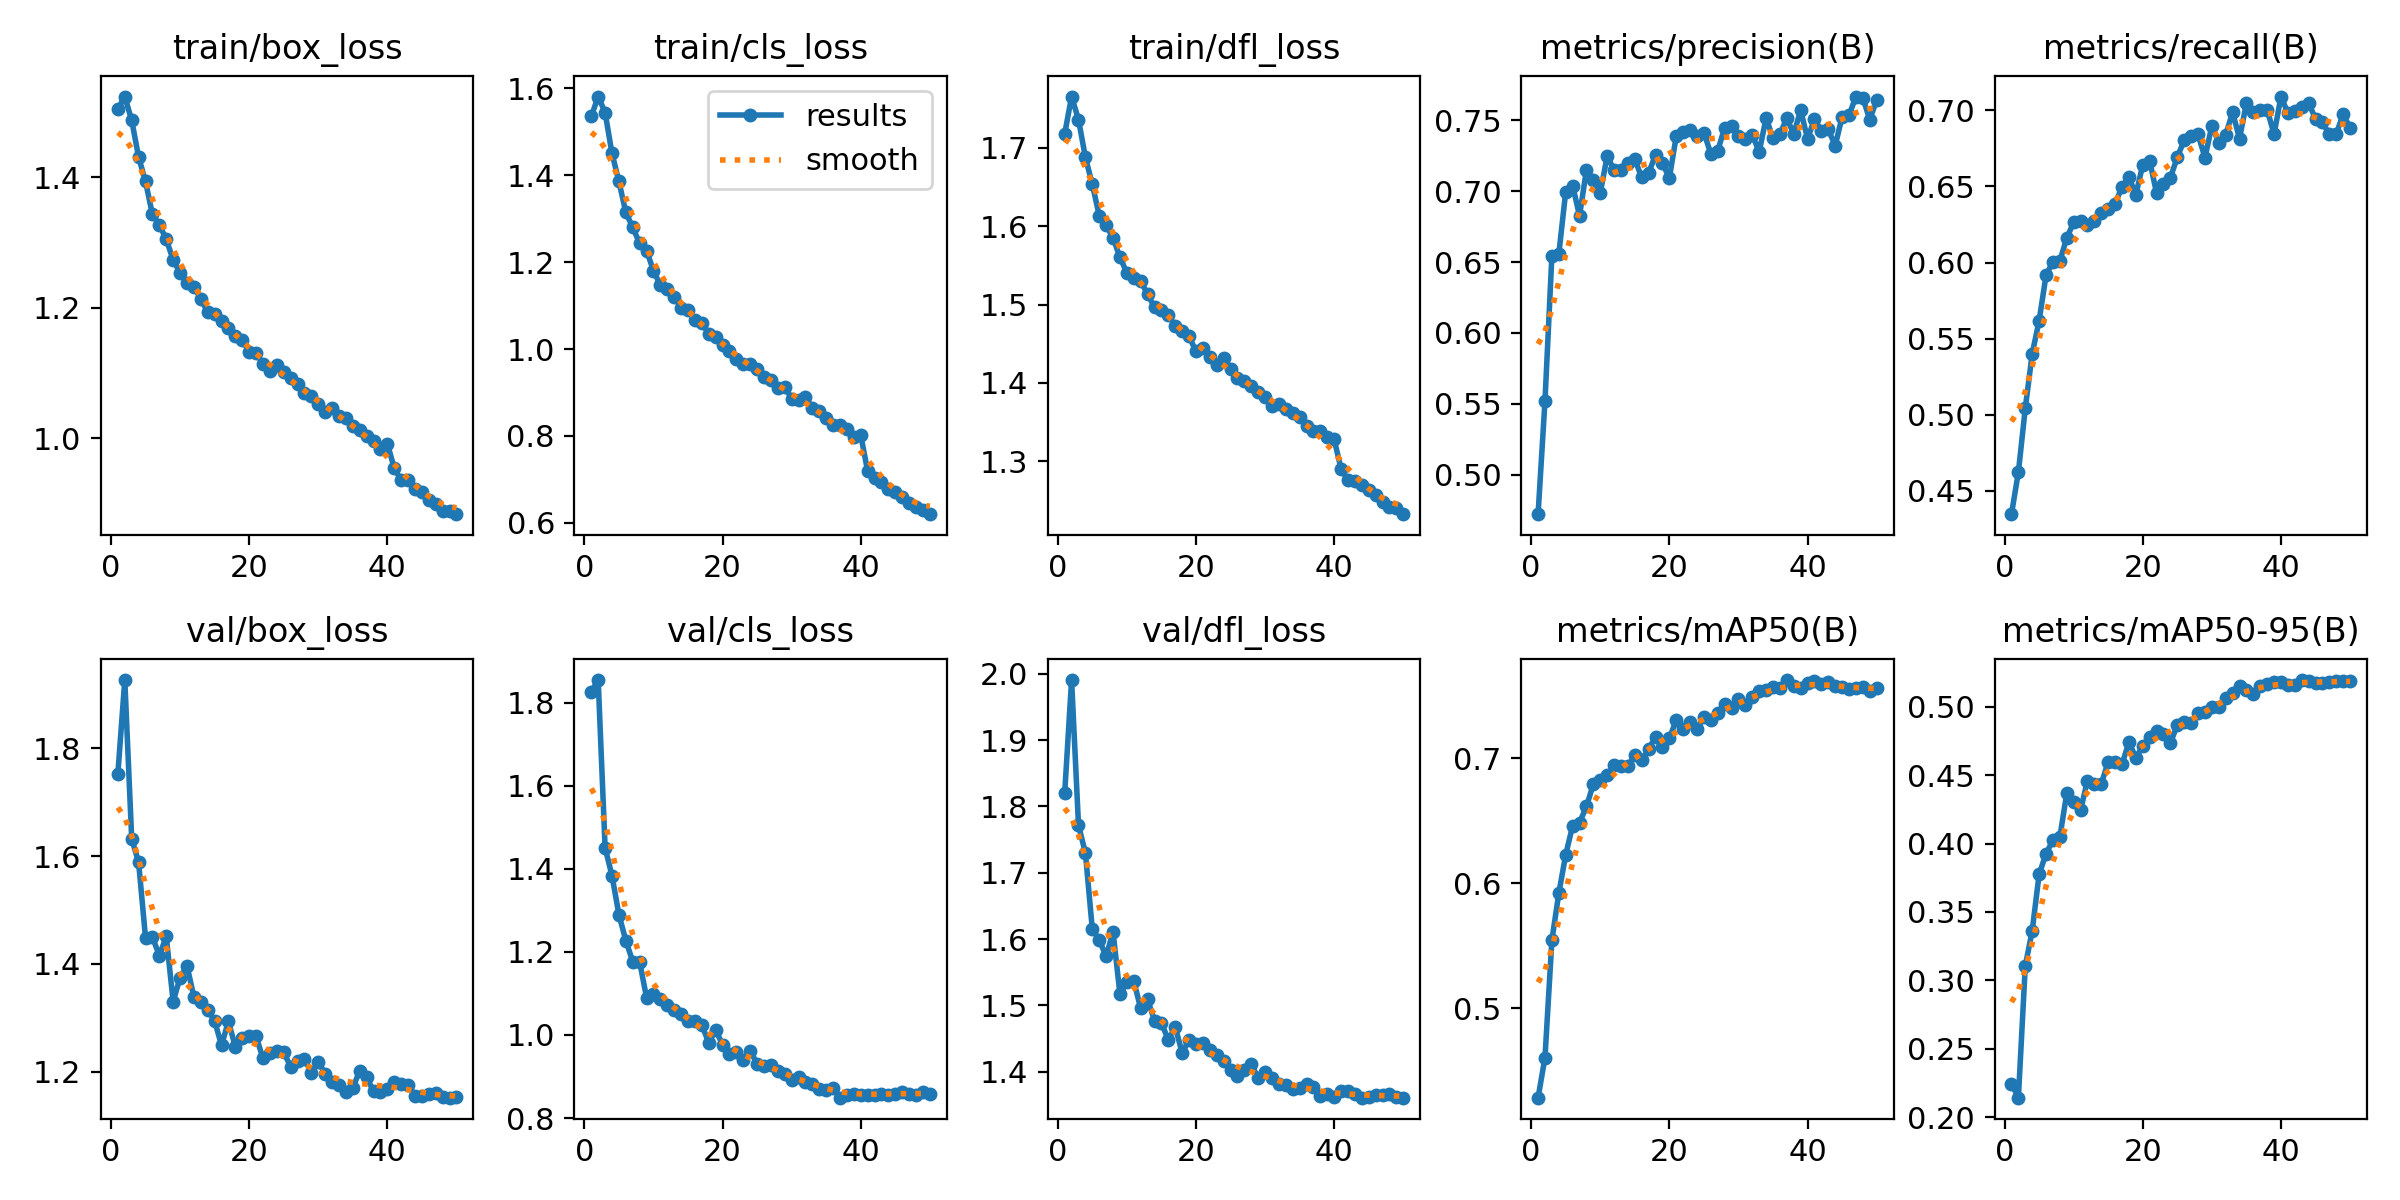

In [11]:
# Visualizar curvas de entrenamiento
results_dir = Path(PROJECT_DIR) / RUN_NAME
results_img = results_dir / "results.png"

if results_img.exists():
    from IPython.display import Image, display
    print("Curvas de entrenamiento:")
    display(Image(filename=str(results_img)))
else:
    print("Archivo results.png no encontrado")

Matriz de confusion:


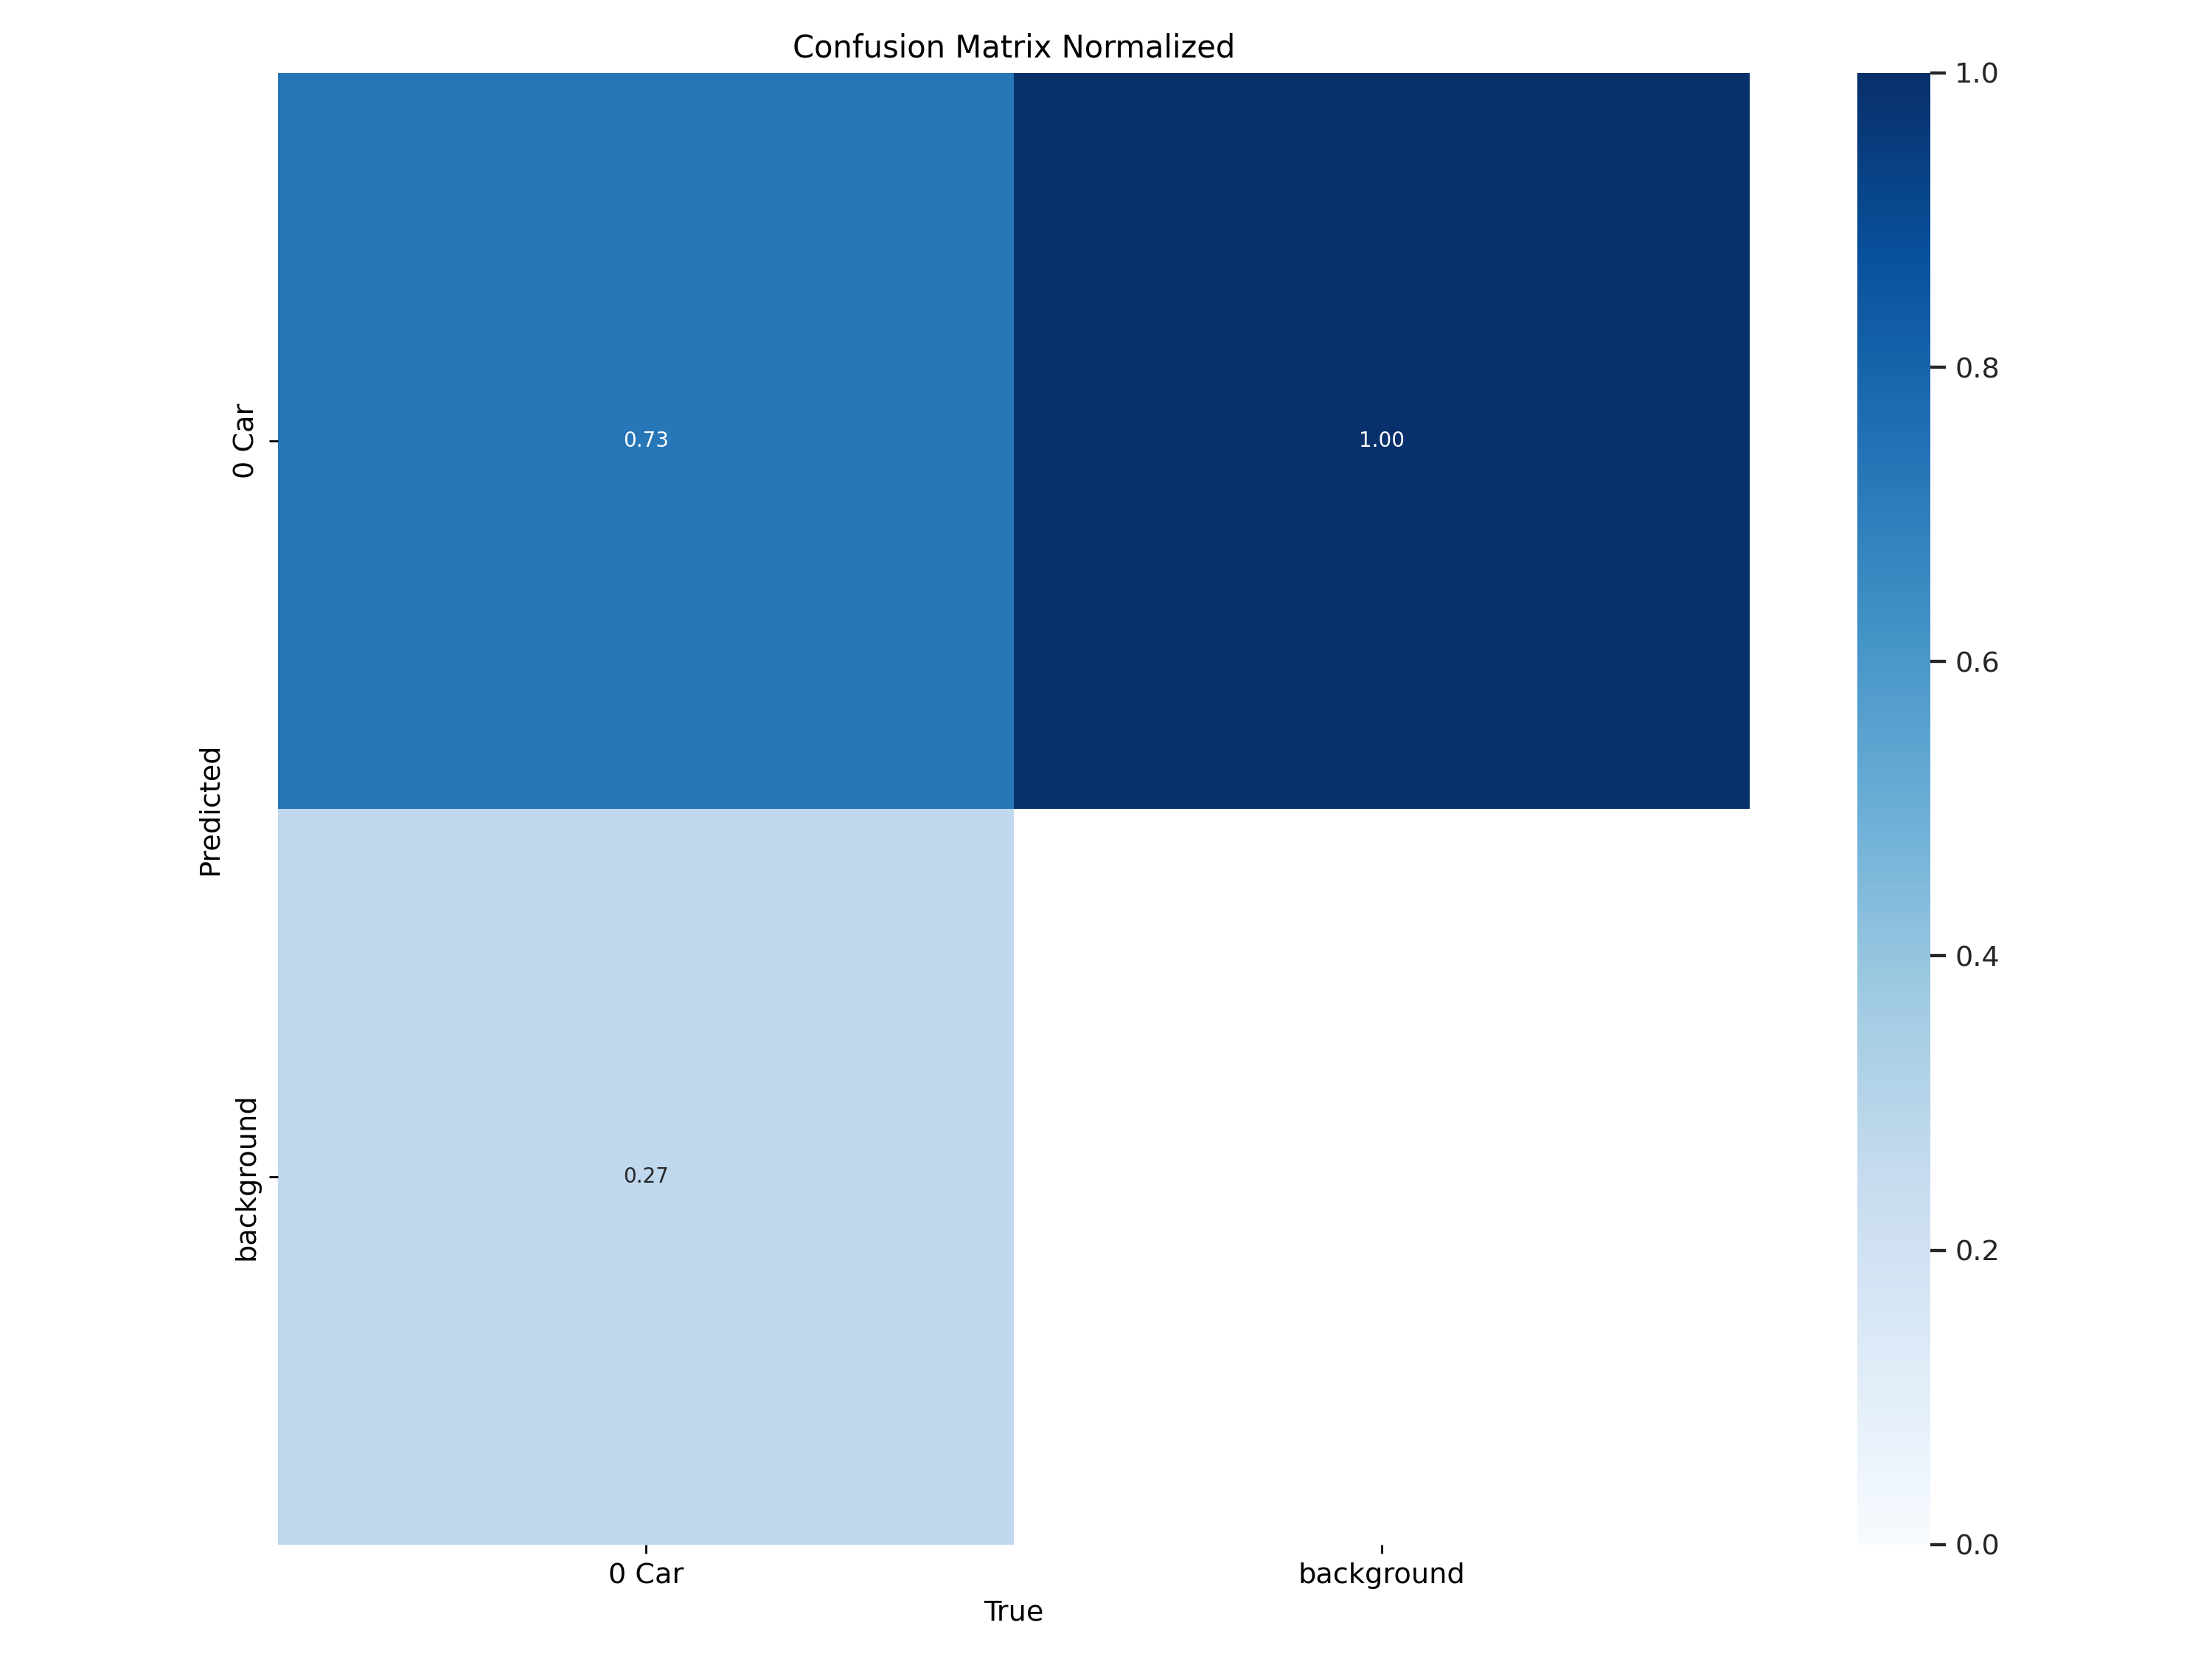

In [12]:
# Visualizar confusion matrix
confusion_img = results_dir / "confusion_matrix_normalized.png"

if confusion_img.exists():
    from IPython.display import Image, display
    print("Matriz de confusion:")
    display(Image(filename=str(confusion_img)))
else:
    print("Confusion matrix no encontrada")

## 5. Pruebas de inferencia

In [13]:
# Inferencia en imagenes de test
test_images_dir = Path(EXTRACT_PATH) / "test" / "images"
test_images = list(test_images_dir.glob("*.jpg"))[:10]  # Primeras 10 imagenes

print(f"Ejecutando inferencia en {len(test_images)} imagenes...\n")

results = model_best.predict(
    source=test_images,
    conf=0.25,        # Umbral de confianza
    iou=0.45,         # NMS threshold
    imgsz=IMG_SIZE,
    save=True,
    save_txt=True,
    save_conf=True,
    project=PROJECT_DIR,
    name="test_predictions",
    exist_ok=True
)

print(f"\nResultados guardados en: {PROJECT_DIR}/test_predictions")

Ejecutando inferencia en 10 imagenes...


0: 640x640 2 0 Cars, 25.2ms
1: 640x640 1 0 Car, 25.2ms
2: 640x640 4 0 Cars, 25.2ms
3: 640x640 7 0 Cars, 25.2ms
4: 640x640 2 0 Cars, 25.2ms
5: 640x640 1 0 Car, 25.2ms
6: 640x640 1 0 Car, 25.2ms
7: 640x640 2 0 Cars, 25.2ms
8: 640x640 1 0 Car, 25.2ms
9: 640x640 4 0 Cars, 25.2ms
Speed: 2.3ms preprocess, 25.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/runs/test_predictions
10 labels saved to /content/runs/test_predictions/labels

Resultados guardados en: /content/runs/test_predictions


In [14]:
# Benchmark de velocidad (importante para webcam en tiempo real)
print("Ejecutando benchmark de velocidad...\n")

test_img = str(test_images[0])
num_runs = 100

# Warmup
for _ in range(10):
    _ = model_best.predict(test_img, imgsz=IMG_SIZE, conf=0.25, verbose=False)

# Benchmark
times = []
for _ in range(num_runs):
    start = time.time()
    _ = model_best.predict(test_img, imgsz=IMG_SIZE, conf=0.25, verbose=False)
    times.append(time.time() - start)

avg_time = sum(times) / len(times)
fps = 1 / avg_time

print("="*60)
print("BENCHMARK DE VELOCIDAD")
print("="*60)
print(f"Latencia promedio: {avg_time*1000:.2f} ms")
print(f"FPS estimado: {fps:.1f}")
print(f"Min latencia: {min(times)*1000:.2f} ms")
print(f"Max latencia: {max(times)*1000:.2f} ms")
print("="*60)

print("\nInterpretacion para webcam:")
if fps >= 30:
    print("✓ Excelente - Video fluido (30+ FPS)")
elif fps >= 20:
    print("✓ Bueno - Suficiente para tiempo real (20+ FPS)")
elif fps >= 10:
    print("⚠ Aceptable - Puede sentirse lento (10-20 FPS)")
else:
    print("✗ Insuficiente - Considerar modelo mas pequeno (<10 FPS)")

print(f"\nNota: Este benchmark es en GPU {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")
print("En produccion, el rendimiento dependera del hardware disponible.")

Ejecutando benchmark de velocidad...

Results saved to /content/runs/test_predictions
10 labels saved to /content/runs/test_predictions/labels
Results saved to /content/runs/test_predictions
10 labels saved to /content/runs/test_predictions/labels
Results saved to /content/runs/test_predictions
10 labels saved to /content/runs/test_predictions/labels
Results saved to /content/runs/test_predictions
10 labels saved to /content/runs/test_predictions/labels
Results saved to /content/runs/test_predictions
10 labels saved to /content/runs/test_predictions/labels
Results saved to /content/runs/test_predictions
10 labels saved to /content/runs/test_predictions/labels
Results saved to /content/runs/test_predictions
10 labels saved to /content/runs/test_predictions/labels
Results saved to /content/runs/test_predictions
10 labels saved to /content/runs/test_predictions/labels
Results saved to /content/runs/test_predictions
10 labels saved to /content/runs/test_predictions/labels
Results saved to 

## 6. Exportar modelo para produccion

In [15]:
# Exportar a diferentes formatos
print("Exportando modelo...\n")

# ONNX (recomendado para produccion multiplataforma)
onnx_path = model_best.export(format="onnx", imgsz=IMG_SIZE)
print(f"✓ ONNX exportado: {onnx_path}")

# TorchScript (para PyTorch en produccion)
torchscript_path = model_best.export(format="torchscript", imgsz=IMG_SIZE)
print(f"✓ TorchScript exportado: {torchscript_path}")

# TFLite (para dispositivos moviles/edge)
# tflite_path = model_best.export(format="tflite", imgsz=IMG_SIZE)
# print(f"✓ TFLite exportado: {tflite_path}")

print("\nFormatos exportados listos para produccion")

Exportando modelo...

Ultralytics 8.3.34 🚀 Python-3.12.12 torch-2.8.0+cu126 CPU (Intel Xeon 2.20GHz)

PyTorch: starting from '/content/runs/car_detector_roboflow_10k/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (49.6 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0', 'onnxslim', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 170.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.5/166.5 kB 230.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.5/300.5 MB 167.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 298.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 358.8 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 25.8s, installed 3 packages: ['onnx>=1.12.0', 'onnxslim', 'onnxruntime-gpu']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


ONNX: starting exp

In [16]:
# Guardar modelo y resultados en Google Drive
DRIVE_OUTPUT = "/content/drive/MyDrive/car_detection_results"
os.makedirs(DRIVE_OUTPUT, exist_ok=True)

# Copiar modelo best.pt
shutil.copy(best_model_path, f"{DRIVE_OUTPUT}/best.pt")
print(f"✓ Modelo guardado en Drive: {DRIVE_OUTPUT}/best.pt")

# Copiar resultados
results_files = [
    "results.png",
    "confusion_matrix.png",
    "confusion_matrix_normalized.png",
    "results.csv"
]

for file in results_files:
    src = results_dir / file
    if src.exists():
        shutil.copy(src, f"{DRIVE_OUTPUT}/{file}")
        print(f"✓ {file} guardado en Drive")

# Guardar modelos exportados
if Path(onnx_path).exists():
    shutil.copy(onnx_path, f"{DRIVE_OUTPUT}/best.onnx")
    print(f"✓ ONNX guardado en Drive")

if Path(torchscript_path).exists():
    shutil.copy(torchscript_path, f"{DRIVE_OUTPUT}/best.torchscript")
    print(f"✓ TorchScript guardado en Drive")

print(f"\n✓ Todos los archivos guardados en: {DRIVE_OUTPUT}")

✓ Modelo guardado en Drive: /content/drive/MyDrive/car_detection_results/best.pt
✓ results.png guardado en Drive
✓ confusion_matrix.png guardado en Drive
✓ confusion_matrix_normalized.png guardado en Drive
✓ results.csv guardado en Drive
✓ ONNX guardado en Drive
✓ TorchScript guardado en Drive

✓ Todos los archivos guardados en: /content/drive/MyDrive/car_detection_results


## 7. Resumen y proximos pasos

In [17]:
print("="*60)
print("RESUMEN DEL ENTRENAMIENTO")
print("="*60)
print(f"\nModelo: {MODEL_SIZE}")
print(f"Dataset: {total_images if 'total_images' in locals() else '10,000'} imagenes")
print(f"Epochs ejecutados: {EPOCHS}")
print(f"\nMejor modelo guardado en:")
print(f"  Local: {best_model_path}")
print(f"  Drive: {DRIVE_OUTPUT}/best.pt")
print(f"\nMetricas finales (test set):")
print(f"  mAP50: {metrics.box.map50:.4f}")
print(f"  mAP50-95: {metrics.box.map:.4f}")
print(f"  Precision: {metrics.box.mp:.4f}")
print(f"  Recall: {metrics.box.mr:.4f}")
print(f"\nVelocidad de inferencia:")
print(f"  Latencia: {avg_time*1000:.2f} ms")
print(f"  FPS: {fps:.1f}")
print("\n" + "="*60)
print("PROXIMOS PASOS")
print("="*60)
print("\n1. Detector de logos de marcas:")
print("   - Usar este modelo para detectar autos")
print("   - Crop de la region del auto detectado")
print("   - Entrenar clasificador de marcas (ResNet/EfficientNet)")
print("\n2. Detector de color:")
print("   - Usar crops del modelo de autos")
print("   - K-Means clustering o clasificador simple")
print("\n3. Lectura de placas:")
print("   - OCR en region detectada del auto")
print("   - Tesseract o EasyOCR")
print("\n4. Integracion en aplicacion web:")
print("   - FastAPI/Flask backend")
print("   - OpenCV para captura de webcam")
print("   - Usar modelo ONNX o TorchScript exportado")
print("="*60)

RESUMEN DEL ENTRENAMIENTO

Modelo: yolov8m.pt
Dataset: 10,000 imagenes
Epochs ejecutados: 50

Mejor modelo guardado en:
  Local: /content/runs/car_detector_roboflow_10k/weights/best.pt
  Drive: /content/drive/MyDrive/car_detection_results/best.pt

Metricas finales (test set):
  mAP50: 0.7792
  mAP50-95: 0.5349
  Precision: 0.7535
  Recall: 0.7192

Velocidad de inferencia:
  Latencia: 29.39 ms
  FPS: 34.0

PROXIMOS PASOS

1. Detector de logos de marcas:
   - Usar este modelo para detectar autos
   - Crop de la region del auto detectado
   - Entrenar clasificador de marcas (ResNet/EfficientNet)

2. Detector de color:
   - Usar crops del modelo de autos
   - K-Means clustering o clasificador simple

3. Lectura de placas:
   - OCR en region detectada del auto
   - Tesseract o EasyOCR

4. Integracion en aplicacion web:
   - FastAPI/Flask backend
   - OpenCV para captura de webcam
   - Usar modelo ONNX o TorchScript exportado


## Notas importantes

### Configuracion de augmentation
- **hsv_h=0.0, hsv_s=0.0**: Sin cambios de color para preservar colores reales (necesario para detector de color futuro)
- **hsv_v=0.2**: Solo variacion de brillo para simular diferentes condiciones de iluminacion
- **degrees=15**: Rotaciones leves (webcam puede estar ligeramente inclinada)
- **flipud=0.0**: Autos nunca aparecen invertidos verticalmente
- **mosaic=0.5**: Reducido para evitar composiciones irreales

### Metricas objetivo
- **mAP50 > 0.85**: Minimo aceptable para produccion
- **Recall > 0.85**: No perder autos en frames de video
- **Precision > 0.80**: Minimizar falsos positivos
- **FPS > 20**: Suficiente para tiempo real en webcam

### Troubleshooting
- **OOM (Out of Memory)**: Reducir BATCH_SIZE a 8 o 4
- **Entrenamiento lento**: Verificar que GPU esta activa con `!nvidia-smi`
- **Metricas bajas**: Aumentar epochs, verificar calidad del dataset
- **FPS bajo**: Usar modelo mas pequeno (yolov8n o yolov8s)

### Archivos importantes
- `best.pt`: Mejor modelo durante entrenamiento (usar en produccion)
- `last.pt`: Ultimo checkpoint (util para reanudar entrenamiento)
- `results.csv`: Metricas por epoch
- `best.onnx`: Modelo exportado para produccion multiplataforma